# 📚 Chapter 2: Ligand-based Screening: Filtering & Similarity Searching

*This notebook contains the code examples in chapter 2. For readability, the chapter notebooks only contain runnable code blocks and section titles. They omit the rest of the material in the book, i.e., text paragraphs, figures (unless generated as part of one of the code blocks), equations, and pseudocode. I recommend reading the notebooks side-by-side with the book!*

You can work through this notebook locally as well as via Google Colab:
<a target="_blank" href="https://colab.research.google.com/github/nrflynn2/ml-drug-discovery/blob/main/CH02_FLYNN_ML4DD.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

This chapter covers
- Virtual screening taxonomy with focus on ligand-based screening
- How to acquire, curate, visualize, and represent molecule datasets
- Compound filtering of undesirable properties and substructures
- Similarity searching to uncover antimalarial hit compounds

## <b> <font color='#A20025'> ⚙️ Environment Setup 

**❗️LOCAL ENVIRONMENT:** If you are running the Python notebook locally on your computer, then we recommend following the README setup instructions on how to use conda (or a similar package) to set up an environment using the file `ml4dd2025.yml`

**❗️COLAB ENVIRONMENT:** If you are running the code via an instance on Google Colab, you can download the necessary files and create the environment by running the following cells marked as **Colab users only**.

In [ ]:
# Colab users only
import os
CHAPTER = "ch02"
os.makedirs(f"artifacts/{CHAPTER}", exist_ok=True)
os.makedirs(f"data/{CHAPTER}", exist_ok=True)
os.makedirs(f"figures/{CHAPTER}", exist_ok=True)
!wget "https://raw.githubusercontent.com/nrflynn2/ml-drug-discovery/main/data/ch02/Specs.sdf.gz" -O "data/ch02/Specs.sdf.gz"
!wget "https://raw.githubusercontent.com/nrflynn2/ml-drug-discovery/main/data/ch02/glaxo_structural_alerts.csv" -O "data/ch02/glaxo_structural_alerts.csv"
!wget "https://raw.githubusercontent.com/nrflynn2/ml-drug-discovery/main/data/ch02/MalariaBox400compoundsDec2014.xls" -O "data/ch02/MalariaBox400compoundsDec2014.xls"
!wget "https://raw.githubusercontent.com/nrflynn2/ml-drug-discovery/main/artifacts/ch02/glaxo_match_df.pkl.gz" -O "artifacts/ch02/glaxo_match_df.pkl.gz"
!wget "https://raw.githubusercontent.com/nrflynn2/ml-drug-discovery/main/artifacts/ch02/specs_filtered.pkl.gz" -O "artifacts/ch02/specs_filtered.pkl.gz"
!wget "https://raw.githubusercontent.com/nrflynn2/ml-drug-discovery/main/artifacts/ch02/specs_ro5_compliant.pkl.gz" -O "artifacts/ch02/specs_ro5_compliant.pkl.gz"
!wget "https://raw.githubusercontent.com/nrflynn2/ml-drug-discovery/main/artifacts/ch02/specs.pkl.gz" -O "artifacts/ch02/spec.pkl.gz"
!wget "https://raw.githubusercontent.com/nrflynn2/ml-drug-discovery/main/artifacts/ch02/specs_ro5_pains_brenk_compliant.pkl.gz" -O "artifacts/ch02/specs_ro5_pains_brenk_compliant.pkl.gz"
!wget "https://raw.githubusercontent.com/nrflynn2/ml-drug-discovery/main/ml4dd2025.yml" -O "env.yml"
!wget "https://raw.githubusercontent.com/nrflynn2/ml-drug-discovery/main/utils.py" -O "utils.py"

In [ ]:
# Colab users only
!pip install -q condacolab
import condacolab
condacolab.install() #  The kernel will restart after this cell has run, which is normal.

In [ ]:
# Colab users only
# Verify condalab installation
import condacolab
condacolab.check()

In [ ]:
# Colab users only
# We can only use the base environment in `condacolab`, so we will update it with the `env.yml` file we downloaded earlier.
!mamba env update -n base -f env.yml

### <b> <font color='#A20025'> Prepare Data Files

First, we'll make sure our data files are ready. The code below will decompress the SDF file we'll be using.

In [1]:
# Check if the file needs to be decompressed
import os
import subprocess

def prepare_data_files():
    """
    Prepare data files for the notebook by decompressing if needed.
    
    Returns:
        bool: True if files are ready
    """
    specs_sdf_path = "data/ch02/Specs.sdf"
    specs_sdf_gz_path = "data/ch02/Specs.sdf.gz"
    
    # Check if the decompressed file already exists
    if os.path.exists(specs_sdf_path):
        print(f"✓ File already exists: {specs_sdf_path}")
        return True
    
    # Check if the compressed file exists
    if not os.path.exists(specs_sdf_gz_path):
        print(f"✗ Compressed file not found: {specs_sdf_gz_path}")
        print("Please download the file from the repository or use the provided data.")
        return False
    
    # Decompress the file
    print(f"Decompressing {specs_sdf_gz_path}...")
    try:
        subprocess.run(['gzip', '-d', specs_sdf_gz_path], check=True)
        print(f"✓ Successfully decompressed file to {specs_sdf_path}")
        return True
    except subprocess.CalledProcessError:
        print("✗ Failed to decompress file using gzip")
        
        # Try with Python's gzip module as a fallback
        try:
            import gzip
            import shutil
            with gzip.open(specs_sdf_gz_path, 'rb') as f_in:
                with open(specs_sdf_path, 'wb') as f_out:
                    shutil.copyfileobj(f_in, f_out)
            print(f"✓ Successfully decompressed file to {specs_sdf_path} using Python")
            return True
        except Exception as e:
            print(f"✗ Failed to decompress file: {str(e)}")
            return False

# Prepare the data files
data_ready = prepare_data_files()
if not data_ready:
    print("\nPlease resolve the data issues before continuing.")

Decompressing data/ch02/Specs.sdf.gz...
✓ Successfully decompressed file to data/ch02/Specs.sdf


### <b> <font color='#A20025'> Import Packages 

Now let's import all the packages we'll need for this chapter.

In [77]:
# Core data science packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

# Chemical informatics packages
from rdkit import Chem
from rdkit.Chem import (
    AllChem, 
    Draw, 
    PandasTools, 
    FilterCatalog, 
    Descriptors, 
    MolFromSmiles, 
    MolFromSmarts,
)
from rdkit import DataStructs
from rdkit.Chem.rdFingerprintGenerator import AdditionalOutput, GetMorganGenerator

# Utility functions
from utils import (
    save_molecular_dataframe,
    load_molecular_dataframe,
    list_saved_dataframes,
)

# Set random seed for reproducibility
np.random.seed(42)

In [3]:
# Matplotlib and Seaborn setup for consistent visualizations
def setup_visualization_style():
    """Configure consistent visualization style for the notebook"""
    plt.style.use('seaborn-v0_8-whitegrid')
    colors = ["#A20025", "#6C8EBF"]  # Define a color palette
    sns.set_palette(sns.color_palette(colors))
    plt.rcParams['axes.titlesize'] = 18
    plt.rcParams['axes.labelsize'] = 16

setup_visualization_style()
%matplotlib inline

In [33]:
# RDKit drawing setup
def setup_rdkit_drawing():
    """Configure RDKit drawing settings for consistent molecular visualizations"""
    d2d = Draw.MolDraw2DSVG(-1, -1)
    dopts = d2d.drawOptions()
    dopts.useBWAtomPalette()
    dopts.setHighlightColour((.635, .0, .145, .4))
    #dopts.baseFontSize = 1.0
    dopts.additionalAtomLabelPadding = 0.15
    dopts.dotsPerAngstrom = 100
    return dopts

rdkit_drawing_options = setup_rdkit_drawing()

## <b> <font color='#A20025'> 1️⃣ What is Virtual Screening?

**Companion code does not accompany this section of the book.**

Virtual screening is a computational technique used in drug discovery to identify potential drug candidates from large chemical libraries. It can be broadly categorized into two approaches:
 
1. **Structure-based virtual screening**: Uses the 3D structure of the target protein to identify molecules that can bind to it.
2. **Ligand-based virtual screening**: Uses the properties of known active compounds to identify similar molecules that might have similar activity.
 
This notebook focuses on **ligand-based virtual screening**, specifically:
 
- Filtering compounds based on physicochemical properties
- Removing compounds with problematic substructures
- Searching for compounds similar to known active molecules

We'll cover these applications in the following sections.

## <b> <font color='#A20025'> 2️⃣ Loading a Virtual Screening Library

First, we'll load a chemical library from a Structure-Data File (SDF), which is a common format for storing chemical structures and associated data.

### <b> <font color='#A20025'> Understanding the Dataset as a Structure Data File

SDF (Structure-Data File) is a file format that contains chemical structures and associated data. Each structure in an SDF has:
- A molecular structure represented in the Mol format
- Optional associated data fields for properties, identifiers, etc.
 
We'll use RDKit's `PandasTools` to load the SDF into a pandas DataFrame. Note that the cell will output a few warnings or errors while processing certain problematic molecules. These are expected and you can ignore them.

**😱 Long Running Code Block**

The following code block may take a long time to run (10 to 12 minutes). This is a great chance to read the corresponding section in the book! But if you want to save time, you can skip this cell and load the resulting, processed data in the cell that comes afterwards.

In [6]:
def load_sdf_file(file_path, smiles_name='smiles', mol_col_name='mol'):
    """
    Load an SDF file into a pandas DataFrame using RDKit.
    
    Parameters:
    -----------
    file_path : str
        Path to the SDF file
    smiles_name : str
        Name to use for the SMILES column
    mol_col_name : str
        Name to use for the molecule column
        
    Returns:
    --------
    pandas.DataFrame
        DataFrame containing the molecules from the SDF
    """
    try:
        # Load SDF file
        print(f"Loading SDF file: {file_path}")
        df = PandasTools.LoadSDF(
            file_path, 
            smilesName=smiles_name, 
            molColName=None
        )
        
        # Keep only essential columns to reduce memory usage
        essential_cols = ["PUBCHEM_SUBSTANCE_ID", smiles_name]
        df = df[essential_cols]
        
        # Add molecule objects
        print("Adding RDKit molecule objects...")
        PandasTools.AddMoleculeColumnToFrame(df, smiles_name, mol_col_name)
        
        # Report basic statistics
        print(f"Loaded {len(df)} compounds")
        print(f"Valid molecules: {df[mol_col_name].notnull().sum()}")
        print(f"Invalid molecules: {df[mol_col_name].isnull().sum()}")
        
        return df
    
    except Exception as e:
        print(f"Error loading SDF file: {str(e)}")
        return None

# Load the Specs SDF file
specs = load_sdf_file("data/ch02/Specs.sdf")

if specs is None:
    print("Failed to load the library. Please check the file path and format.")
else:
    # Show a sample of the data
    print("\nSample data:")
    display(specs.head(3))

Loading SDF file: data/ch02/Specs.sdf


[16:33:49] Warning: ambiguous stereochemistry - opposing bonds have opposite wedging - at atom 2 ignored.
[16:33:49] Warning: ambiguous stereochemistry - opposing bonds have opposite wedging - at atom 2 ignored.
[16:34:16] Explicit valence for atom # 9 N, 4, is greater than permitted
[16:34:16] ERROR: Could not sanitize molecule ending on line 6498564
[16:34:16] ERROR: Explicit valence for atom # 9 N, 4, is greater than permitted
[16:35:03] Explicit valence for atom # 9 N, 4, is greater than permitted
[16:35:03] ERROR: Could not sanitize molecule ending on line 8305274
[16:35:03] ERROR: Explicit valence for atom # 9 N, 4, is greater than permitted
[16:35:03] Explicit valence for atom # 10 N, 4, is greater than permitted
[16:35:03] ERROR: Could not sanitize molecule ending on line 8315499
[16:35:03] ERROR: Explicit valence for atom # 10 N, 4, is greater than permitted
[16:35:31] Warning: ambiguous stereochemistry - opposing bonds have opposite wedging - at atom 3 ignored.
[16:35:31] War

Adding RDKit molecule objects...
Loaded 212670 compounds
Valid molecules: 212670
Invalid molecules: 0

Sample data:


,PUBCHEM_SUBSTANCE_ID,smiles,mol
0,469753576,COc1ccc(N2C(=O)CC2(C(=O)Nc2c(C)cccc2C)c2ccc(C)...,<rdkit.Chem.rdchem.Mol object at 0x7f75bf0610e0>
1,469753575,CCOC(=O)c1ccc(NC2SC(=O)N(Cc3ccc(C(=O)OC)cc3)C2...,<rdkit.Chem.rdchem.Mol object at 0x7f75bf063ed0>
2,469753574,Cc1cc(Br)cc([N+](=O)[O-])c1N,<rdkit.Chem.rdchem.Mol object at 0x7f75bf063df0>


In [52]:
#save_molecular_dataframe(specs, "specs", chapter="ch02")

Saving dataframe with 212670 rows to data/ch02/artifacts/specs.pkl.gz...
Successfully saved dataframe (102.4 MB)


'data/ch02/artifacts/specs.pkl.gz'

If you skipped the above, long running code block, then you can load the necessary artifact (takes ~30 to 60 seconds) by running the below code block.

In [ ]:
specs = load_molecular_dataframe("specs", chapter="ch02")

Let's take a closer look at one of the molecules in our dataset:

Molecule type: <class 'rdkit.Chem.rdchem.Mol'>
Number of atoms: 30
Number of bonds: 33


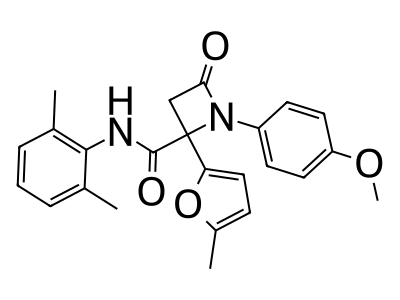

Molecule image saved to 'figures/ch02/example_mol.svg'


In [7]:
def examine_molecule(df, index=0, mol_col='mol', draw=True):
    """
    Examine a single molecule from the dataset.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame containing molecules
    index : int
        Index of the molecule to examine
    mol_col : str
        Name of the column containing RDKit molecule objects
    draw : bool
        Whether to draw the molecule
        
    Returns:
    --------
    rdkit.Chem.rdchem.Mol
        RDKit molecule object
    """
    # Get the molecule
    mol = df[mol_col].iloc[index]
    
    # Print basic information
    print(f"Molecule type: {type(mol)}")
    print(f"Number of atoms: {mol.GetNumAtoms()}")
    print(f"Number of bonds: {mol.GetNumBonds()}")
    
    # Draw the molecule if requested
    if draw:
        img = Draw.MolsToGridImage(
            mols=[mol], 
            molsPerRow=1, 
            subImgSize=(400, 300),
            useSVG=True, 
            drawOptions=rdkit_drawing_options
        )
        display(img)
        
        # Save the image
        with open("figures/ch02/example_mol.svg", "w") as f:
            f.write(img.data)
        print("Molecule image saved to 'figures/ch02/example_mol.svg'")
    
    return mol

# Examine the first molecule in the dataset
sample_mol = examine_molecule(specs, index=0)

### <b> <font color='#A20025'> Molecular Descriptors

Molecular descriptors are numerical values that characterize properties of molecules. RDKit provides a wide range of descriptors, which we'll use to filter compounds based on Lipinski's Rule of Five (RO5).

In [8]:
def list_available_descriptors(limit=10):
    """
    List available molecular descriptors in RDKit.
    
    Parameters:
    -----------
    limit : int
        Number of descriptors to show (0 for all)
    """
    descriptors = Descriptors._descList
    print(f"RDKit has {len(descriptors)} molecular descriptors available")
    
    if limit > 0:
        print(f"Showing first {min(limit, len(descriptors))} descriptors:")
        for name, func in descriptors[:limit]:
            print(f"- {name}")
    
    return {desc: func for desc, func in descriptors}

# List available descriptors
RDKIT_DESCRIPTORS = list_available_descriptors(limit=10)

RDKit has 210 molecular descriptors available
Showing first 10 descriptors:
- MaxAbsEStateIndex
- MaxEStateIndex
- MinAbsEStateIndex
- MinEStateIndex
- qed
- SPS
- MolWt
- HeavyAtomMolWt
- ExactMolWt
- NumValenceElectrons


Lipinski's Rule of Five is a set of guidelines for drug-like molecules:
1. Molecular weight < 500 Daltons
2. Octanol-water partition coefficient (LogP) < 5
3. Hydrogen bond donors < 5
4. Hydrogen bond acceptors < 10
 
Let's calculate these properties for our molecules:

In [9]:
def calculate_ro5_descriptors(df, mol_col='mol'):
    """
    Calculate Lipinski's Rule of Five descriptors for a set of molecules.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame containing molecules
    mol_col : str
        Name of the column containing RDKit molecule objects
        
    Returns:
    --------
    pandas.DataFrame
        DataFrame with added descriptors
    """
    # Define RO5 properties to calculate
    RO5_PROPS = ['ExactMolWt', 'NumHAcceptors', 'NumHDonors', 'MolLogP']
    
    # Function to safely compute descriptors
    def compute_descriptor(mol, func_name, missing_val=None):
        if mol is None:
            return missing_val
        try:
            func = RDKIT_DESCRIPTORS[func_name]
            return func(mol)
        except:
            return missing_val
    
    # Calculate each descriptor
    print("Calculating molecular descriptors...")
    for desc in RO5_PROPS:
        df[desc] = df[mol_col].apply(
            lambda x: compute_descriptor(x, desc)
        )
    
    # Remove rows with missing values
    row_count_before = len(df)
    df = df.dropna(subset=RO5_PROPS)
    row_count_after = len(df)
    
    print(f"Removed {row_count_before - row_count_after} rows with missing descriptor values")
    print(f"Remaining molecules: {row_count_after}")
    
    return df

# Calculate RO5 descriptors
specs = calculate_ro5_descriptors(specs)

# Show summary statistics
print("\nSummary statistics for RO5 properties:")
display(specs[['ExactMolWt', 'NumHAcceptors', 'NumHDonors', 'MolLogP']].describe())

Calculating molecular descriptors...
Removed 0 rows with missing descriptor values
Remaining molecules: 212670

Summary statistics for RO5 properties:


,ExactMolWt,NumHAcceptors,NumHDonors,MolLogP
count,212670.000000,212670.000000,212670.000000,212670.000000
mean,371.738321,4.512531,0.990046,3.917192
std,93.585321,1.905391,0.796672,1.587613
min,68.025421,0.000000,0.000000,-4.195200
25%,306.136828,3.000000,0.000000,2.885940
50%,369.020203,4.000000,1.000000,3.855710
75%,432.133005,6.000000,1.000000,4.923815
max,1161.548016,21.000000,8.000000,15.329400


## <b> <font color='#A20025'> 3️⃣ Compound Filters

Now we'll apply filters to our compound library to remove molecules with undesirable properties or substructures.

### <b> <font color='#A20025'> Property-based Filters: Lipinski's Rule of Five

We'll filter compounds based on Lipinski's Rule of Five, which states that drug-like molecules should generally have:
- Molecular weight ≤ 500
- LogP ≤ 5
- Hydrogen bond donors ≤ 5
- Hydrogen bond acceptors ≤ 10
 
A compound is considered compliant if it violates no more than one rule.

In [10]:
def apply_lipinski_filter(df):
    """
    Apply Lipinski's Rule of Five filter to a set of molecules.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame containing molecules with RO5 descriptors
        
    Returns:
    --------
    pandas.DataFrame
        DataFrame with added RO5 compliance column
    """
    def count_ro5_violations(row):
        """Count the number of Lipinski's Rule of Five violations for a molecule"""
        violations = 0
        if row['ExactMolWt'] > 500: violations += 1
        if row['MolLogP'] > 5: violations += 1
        if row['NumHDonors'] > 5: violations += 1
        if row['NumHAcceptors'] > 10: violations += 1
        return violations
    
    # Add columns for RO5 violations and compliance
    df['ro5_violations'] = df.apply(count_ro5_violations, axis=1)
    df['ro5_compliant'] = df['ro5_violations'] <= 1
    
    # Split into compliant and non-compliant sets
    compliant_df = df[df['ro5_compliant']]
    violated_df = df[~df['ro5_compliant']]
    
    # Report results
    print(f"Compound library size pre-RO5 filter: {len(df)}")
    print(f"Compound library size post-RO5 filter: {len(compliant_df)}")
    print(f"Removed compounds: {len(violated_df)}")
    print(f"Percentage of compounds passing the filter: {len(compliant_df) / len(df) * 100:.1f}%")
    
    return df, compliant_df, violated_df

# Apply Lipinski's Rule of Five filter
specs, specs_ro5_compliant, specs_ro5_violated = apply_lipinski_filter(specs)

Compound library size pre-RO5 filter: 212670
Compound library size post-RO5 filter: 199481
Removed compounds: 13189
Percentage of compounds passing the filter: 93.8%


Let's visualize the effect of Lipinski filtering on our dataset.

Figure saved to figures/ch02/exactmolwt_dist_exactmolwt.png and figures/ch02/exactmolwt_dist_exactmolwt.pdf


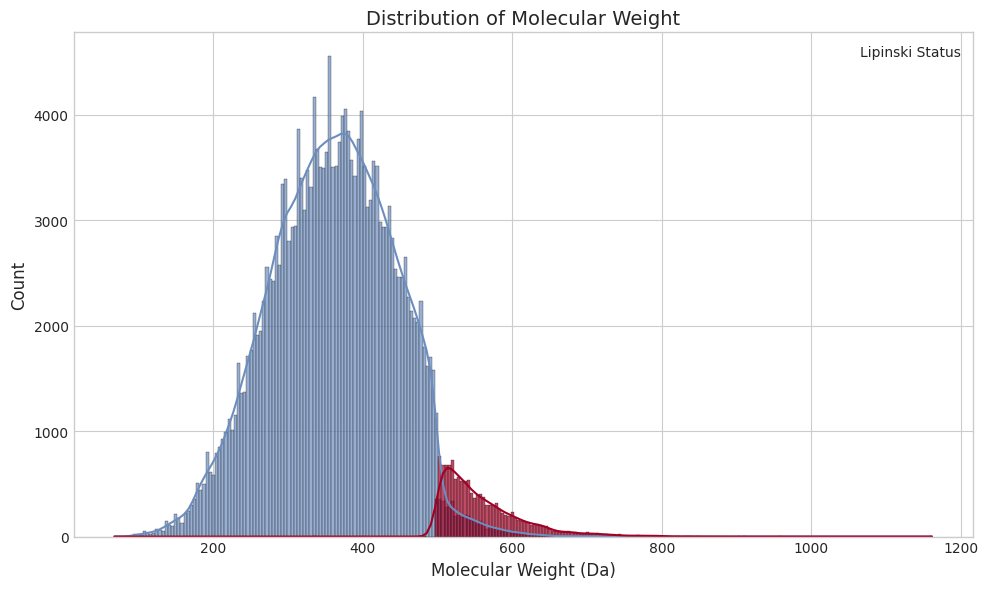

In [18]:
def visualize_property_distribution(df, property_col, hue_col='ro5_compliant', 
                                   title=None, x_label=None, file_prefix=None):
    """
    Visualize the distribution of a molecular property.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame containing molecules
    property_col : str
        Name of the property column to visualize
    hue_col : str
        Name of the column to use for coloring
    title : str
        Title for the plot
    x_label : str
        Label for the x-axis
    file_prefix : str
        Prefix for saved files
        
    Returns:
    --------
    matplotlib.figure.Figure
        Figure containing the plot
    """
    plt.figure(figsize=(10, 6))
    
    # Create the distribution plot
    ax = sns.histplot(
        data=df, 
        x=property_col, 
        hue=hue_col,
        multiple="layer",
        palette=["#A20025", "#6C8EBF"],
        alpha=0.7,
        kde=True
    )
    
    # Add title and labels
    if title:
        ax.set_title(title, fontsize=14)
    if x_label:
        ax.set_xlabel(x_label, fontsize=12)
    ax.set_ylabel("Count", fontsize=12)
    
    # Add a legend with better labels
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, ["Non-compliant", "RO5 Compliant"], title="Lipinski Status")
    
    plt.tight_layout()
    
    # Save the figure if requested
    if file_prefix:
        file_path = f"figures/ch02/{file_prefix}_{property_col.lower()}.png"
        plt.savefig(file_path, bbox_inches='tight', dpi=600)
        pdf_path = f"figures/ch02/{file_prefix}_{property_col.lower()}.pdf"
        plt.savefig(pdf_path, bbox_inches='tight', dpi=600)
        print(f"Figure saved to {file_path} and {pdf_path}")
    
    return plt.gcf()

# Visualize molecular weight distribution
mw_fig = visualize_property_distribution(
    specs, 
    'ExactMolWt', 
    title='Distribution of Molecular Weight', 
    x_label='Molecular Weight (Da)',
    file_prefix='exactmolwt_dist'
)

Now we'll compare property differences between RO5 complient and non-compliant compounds

Property comparison between RO5 compliant and non-compliant compounds:


,property,RO5 Compliant Mols,RO5 Violated Mols,rel_change
0,NumHAcceptors,4.398524,6.236864,-29.475388
1,NumHDonors,0.994050,0.929487,6.946077
2,MolLogP,3.745281,6.517303,-42.533264


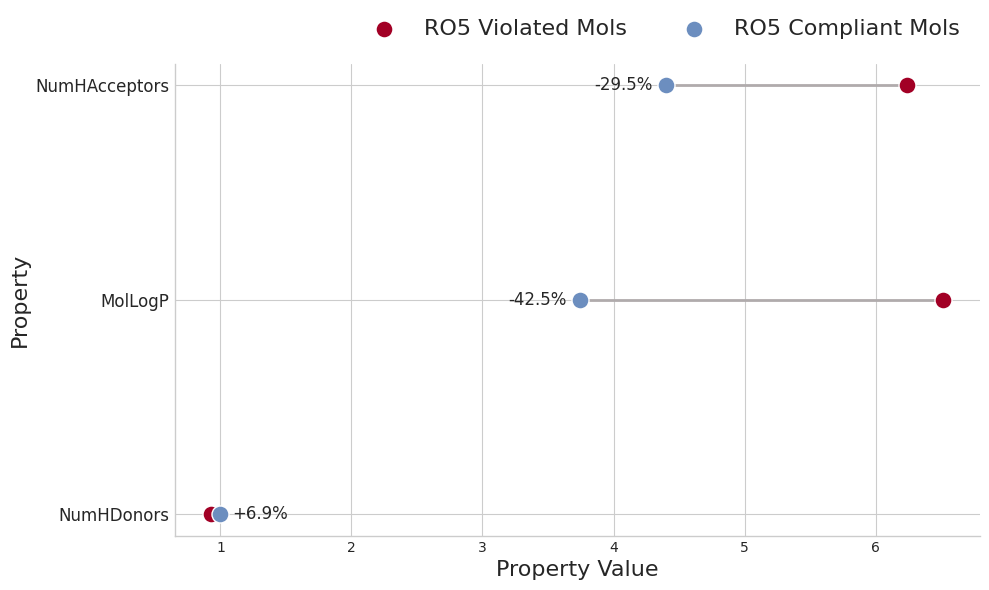

In [22]:
def compare_properties_between_groups(compliant_df, violated_df, properties):
    """
    Compare molecular properties between two groups.
    
    Parameters:
    -----------
    compliant_df : pandas.DataFrame
        DataFrame containing the first group
    violated_df : pandas.DataFrame
        DataFrame containing the second group
    properties : list
        List of property columns to compare
        
    Returns:
    --------
    pandas.DataFrame
        DataFrame with property differences
    """
    # Calculate mean values for each property in each group
    data = []
    
    for prop in properties:
        compliant_mean = compliant_df[prop].mean()
        violated_mean = violated_df[prop].mean()
        rel_change = (compliant_mean - violated_mean) / violated_mean * 100
        
        data.append({
            'property': prop,
            'RO5 Compliant Mols': compliant_mean,
            'RO5 Violated Mols': violated_mean,
            'rel_change': rel_change
        })
    
    # Create dataframe
    comparison_df = pd.DataFrame(data)
    return comparison_df

def visualize_property_differences(comparison_df):
    """
    Visualize the differences in properties between two groups.
    
    Parameters:
    -----------
    comparison_df : pandas.DataFrame
        DataFrame with property differences
        
    Returns:
    --------
    matplotlib.figure.Figure
        Figure containing the plot
    """
    # Sort by property values
    ordered_df = comparison_df.sort_values(by='RO5 Compliant Mols')
    my_range = range(1, len(ordered_df.index) + 1)
    
    # Create the plot
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Draw horizontal lines connecting the points
    ax.hlines(
        y=my_range, 
        xmin=ordered_df['RO5 Violated Mols'], 
        xmax=ordered_df['RO5 Compliant Mols'], 
        color='#B0ABAC',
        linewidth=2
    )
    
    # Add percentage change annotations
    for x, y, ann in zip(ordered_df['RO5 Compliant Mols'], my_range, ordered_df['rel_change']):
        if ann < 0:
            ax.text(x - 0.1, y, f'{ann:.1f}%', ha='right', va='center', fontsize=12)
        else:
            ax.text(x + 0.1, y, f'+{ann:.1f}%', ha='left', va='center', fontsize=12)
    
    # Plot data points
    ax.scatter(
        ordered_df['RO5 Violated Mols'], my_range, 
        s=150, color='#A20025', label="RO5 Violated Mols",
        zorder=3, edgecolor='white', linewidth=1
    )
    ax.scatter(
        ordered_df['RO5 Compliant Mols'], my_range, 
        s=150, color='#6C8EBF', label="RO5 Compliant Mols",
        zorder=3, edgecolor='white', linewidth=1
    )
    
    # Configure the plot
    ax.set_yticks(my_range)
    ax.set_yticklabels(ordered_df['property'], fontsize=12)
    ax.set_xlabel('Property Value', fontsize=16)
    ax.set_ylabel('Property', fontsize=16)
    #ax.set_title('Property Differences Between RO5 Compliant and Non-Compliant Molecules', fontsize=14)
    
    # Remove frame
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # Add legend
    ax.legend(ncol=2, bbox_to_anchor=(1., 1.01), loc="lower right", frameon=False, fontsize=16)
    
    plt.tight_layout()
    
    # Save the figure
    plt.savefig('figures/ch02/relchange_ro5.png', bbox_inches='tight', dpi=600)
    plt.savefig('figures/ch02/relchange_ro5.pdf', bbox_inches='tight', dpi=600)
    
    return fig

# Compare RO5 properties between compliant and non-compliant compounds
properties_to_compare = ['NumHAcceptors', 'NumHDonors', 'MolLogP']
comparison_df = compare_properties_between_groups(
    specs_ro5_compliant, 
    specs_ro5_violated, 
    properties_to_compare
)

# Display the comparison
print("Property comparison between RO5 compliant and non-compliant compounds:")
display(comparison_df)

# Visualize the differences
diff_fig = visualize_property_differences(comparison_df)

### <b> <font color='#A20025'> Structure-based Filters

In addition to property-based filters, we can also filter compounds based on structural features. Certain substructures are known to be problematic in drug discovery due to:
 
- **Reactivity**: Compounds that may degrade or react undesirably
- **Assay interference**: Compounds that can interfere with biological assays (PAINS: Pan-Assay Interference Compounds)
- **Toxicity**: Compounds with potentially harmful effects
 
We'll apply three types of structural filters:
1. **PAINS filters**: To remove pan-assay interference compounds that can interfere with biological assays by various mechanisms, leading to false positives.
2. **BRENK filters**: To remove compounds with problematic functional groups
3. **Glaxo Wellcome filters**: To remove compounds with reactive or toxic groups

We'll start by applying PAINS and BRENK filters.

**😱 Long Running Code Block**

The following code block may take a long time to run (20 to 25 minutes). If you want to save time, you can skip this cell and load the resulting, filtering data in the cell that comes afterwards.

In [23]:
def apply_pains_brenk_filters(df, mol_col='mol'):
    """
    Apply PAINS and BRENK filters to a set of molecules.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame containing molecules
    mol_col : str
        Name of the column containing RDKit molecule objects
        
    Returns:
    --------
    pandas.DataFrame
        DataFrame with added filter compliance column
    """
    # Ensures we're working with a new DataFrame, not a view
    df_copy = df.copy()

    # Initialize the filter catalog
    print("Initializing PAINS and BRENK filters...")
    filter_params = FilterCatalog.FilterCatalogParams()
    filter_params.AddCatalog(filter_params.FilterCatalogs.PAINS)
    filter_params.AddCatalog(filter_params.FilterCatalogs.BRENK)
    catalog = FilterCatalog.FilterCatalog(filter_params)
    
    # Apply the filters (HasMatch returns True for problematic compounds)
    print("Applying filters to molecules...")
    df_copy.loc[:, 'PAINS_BRENK_match'] = df_copy[mol_col].apply(catalog.HasMatch)
    df_copy.loc[:, 'PAINS_BRENK_compliant'] = ~df_copy['PAINS_BRENK_match']
    
    # Filter the dataframe
    filtered_df = df_copy[df_copy['PAINS_BRENK_compliant']]
    
    # Report results
    print(f"Compounds before PAINS/BRENK filter: {len(df_copy)}")
    print(f"Compounds failing PAINS/BRENK filter: {len(df_copy) - len(filtered_df)}")
    print(f"Compounds after PAINS/BRENK filter: {len(filtered_df)}")
    print(f"Percentage of compounds passing the filter: {len(filtered_df) / len(df_copy) * 100:.1f}%")
    
    return df_copy, filtered_df

# Apply PAINS and BRENK filters to the RO5 compliant compounds
specs_ro5_compliant, specs_ro5_pains_brenk_compliant = apply_pains_brenk_filters(specs_ro5_compliant)

# After computing RO5 and PAINS/BRENK filters, save the results
save_molecular_dataframe(specs_ro5_compliant, "specs_ro5_compliant", chapter="ch02")
save_molecular_dataframe(specs_ro5_pains_brenk_compliant, "specs_ro5_pains_brenk_compliant", chapter="ch02")

Initializing PAINS and BRENK filters...
Applying filters to molecules...


/tmp/ipykernel_2761/4125902353.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['PAINS_BRENK_match'] = df[mol_col].apply(catalog.HasMatch)
/tmp/ipykernel_2761/4125902353.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['PAINS_BRENK_compliant'] = ~df['PAINS_BRENK_match']


Compounds before PAINS/BRENK filter: 199481
Compounds failing PAINS/BRENK filter: 93915
Compounds after PAINS/BRENK filter: 105566
Percentage of compounds passing the filter: 52.9%


If you skipped the above, long running code block, then you can load the necessary artifacts (takes ~30 to 60 seconds) by running the below code block.

In [51]:
specs_ro5_compliant = load_molecular_dataframe("specs_ro5_compliant", chapter="ch02")
specs_ro5_pains_brenk_compliant = load_molecular_dataframe("specs_ro5_pains_brenk_compliant", chapter="ch02")

Loading molecular dataframe from data/ch02/artifacts/specs_ro5_compliant.pkl.gz...
Successfully loaded dataframe with 199481 rows and 11 columns
Loading time: 44.27 seconds
Loading molecular dataframe from data/ch02/artifacts/specs_ro5_pains_brenk_compliant.pkl.gz...
Successfully loaded dataframe with 105566 rows and 13 columns
Loading time: 20.52 seconds


Now we'll apply the Glaxo Wellcome hard filters, which are a set of substructural filters developed to identify compounds with problematic functionalities. These filters were designed to flag compounds that might:
- React with proteins through electrophilic mechanisms
- Form reactive metabolites
- Cause toxicity through specific mechanisms
- Have poor stability or other undesirable properties

Loaded 55 Glaxo Wellcome structural alerts

Example structural alerts:


,description,smarts
0,Reactive alkyl halides,"[Br,Cl,I][CX4;CH,CH2]"
1,Acid halides,"[S,C](=[O,S])[F,Br,Cl,I]"
2,Carbazides,O=CN=[N+]=[N-]
3,Sulphate esters,"COS(=O)O[C,c]"
4,Sulphonates,"COS(=O)(=O)[C,c]"


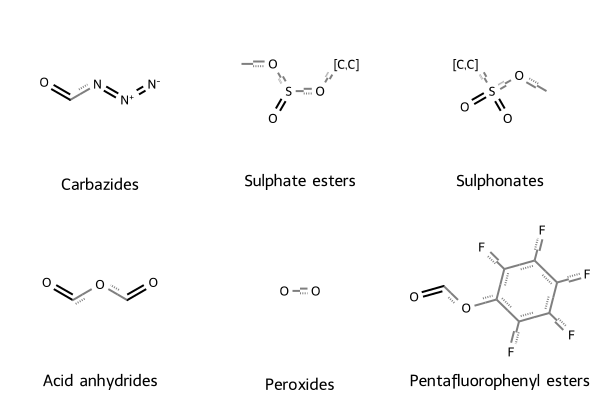

Alert visualization saved to 'figures/ch02/glaxo_alerts_examples.svg'


In [63]:
def load_glaxo_alerts():
    """
    Load Glaxo Wellcome structural alerts from a CSV file.
    
    Returns:
    --------
    pandas.DataFrame
        DataFrame containing the structural alerts
    """
    try:
        alerts_df = pd.read_csv("data/ch02/glaxo_structural_alerts.csv")
        alerts_df["ROMol"] = alerts_df.smarts.apply(MolFromSmarts)
        
        # Check for invalid SMARTS patterns
        invalid_count = alerts_df.ROMol.isnull().sum()
        if invalid_count > 0:
            print(f"Warning: {invalid_count} invalid SMARTS patterns detected")
            alerts_df = alerts_df.dropna(subset=['ROMol'])
        
        print(f"Loaded {len(alerts_df)} Glaxo Wellcome structural alerts")
        return alerts_df
    
    except Exception as e:
        print(f"Error loading Glaxo alerts: {str(e)}")
        return None

def visualize_structural_alerts(alerts_df, start_idx=2, n_alerts=6):
    """
    Visualize example structural alerts.
    
    Parameters:
    -----------
    alerts_df : pandas.DataFrame
        DataFrame containing structural alerts
    start_idx : int
        Index to start from
    n_alerts : int
        Number of alerts to visualize
        
    Returns:
    --------
    rdkit.Chem.Draw._MolsToGridImage
        Grid image of alert substructures
    """
    end_idx = start_idx + n_alerts
    if end_idx > len(alerts_df):
        end_idx = len(alerts_df)
        print(f"Warning: Requested more alerts than available. Showing {end_idx - start_idx} alerts.")
    
    alert_mols = alerts_df["ROMol"].iloc[start_idx:end_idx].tolist()
    alert_names = alerts_df["description"].iloc[start_idx:end_idx].tolist()
    
    # Calculate grid dimensions
    n_cols = min(3, n_alerts)
    
    # Create the visualization
    img = Draw.MolsToGridImage(
        mols=alert_mols, 
        molsPerRow=n_cols, 
        legends=alert_names, 
        useSVG=True, 
        drawOptions=rdkit_drawing_options
    )
    
    return img

# Load the Glaxo Wellcome structural alerts
glaxo_alerts = load_glaxo_alerts()

# Display a few examples
print("\nExample structural alerts:")
display(glaxo_alerts[['description', 'smarts']].head(5))
    
# Visualize example alerts
alerts_img = visualize_structural_alerts(glaxo_alerts, start_idx=2, n_alerts=6)
display(alerts_img)

# Save the visualization
with open("figures/ch02/glaxo_alerts_examples.svg", "w") as f:
    f.write(alerts_img.data)
print("Alert visualization saved to 'figures/ch02/glaxo_alerts_examples.svg'")

**😱 Long Running Code Block**

The following code block may take a long time to run (13 to 15 minutes; there is a much more efficient implementation but we use a naive implementation to record certain instructional statistics about the SMARTS used in the filter). If you want to save time, you can skip this cell and load the resulting, filtered data in the cell that comes afterwards.

In [65]:
# Now apply the Glaxo filters to our dataset
def apply_glaxo_filters(df, alerts, mol_col='mol'):
    """
    Apply Glaxo Wellcome structural filters to a set of molecules.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame containing molecules
    alerts : pandas.DataFrame
        DataFrame containing structural alerts
    mol_col : str
        Name of the column containing RDKit molecule objects
        
    Returns:
    --------
    pandas.DataFrame
        DataFrame with added filter compliance column
    list
        List of dictionaries with match information
    """
    glaxo_sa_matches = []
    
    def check_glaxo_match(mol, alerts_df):
        """Check if a molecule contains any Glaxo alert substructures"""
        match_ = False
        for _, alert in alerts_df.iterrows():
            if mol.HasSubstructMatch(alert.ROMol):
                glaxo_sa_matches.append({
                    "mol": mol,
                    "alert": alert.ROMol,
                    "description": alert.description,
                })
                match_ = True
        return match_
    
    print("Applying Glaxo Wellcome filters...")
    df['GLAXO_match'] = df[mol_col].apply(check_glaxo_match, alerts_df=alerts)
    df['GLAXO_compliant'] = ~df['GLAXO_match']

    # Filter the dataframe
    filtered_df = df[df['GLAXO_compliant']]
    
    # Report results
    print(f"Compounds before Glaxo filter: {len(df)}")
    print(f"Compounds failing Glaxo filter: {len(df) - len(filtered_df)}")
    print(f"Compounds after Glaxo filter: {len(filtered_df)}")
    print(f"Percentage of compounds passing the filter: {len(filtered_df) / len(df) * 100:.1f}%")
    
    # Convert match list to DataFrame for easier analysis
    match_df = pd.DataFrame(glaxo_sa_matches)
    
    if not match_df.empty:
        print("\nTop 5 most common Glaxo alert matches:")
        display(match_df["description"].value_counts().head(5))
    
    return df, filtered_df, match_df

# Apply Glaxo filters to the PAINS/BRENK compliant compounds
specs_ro5_pains_brenk_compliant, specs_filtered, glaxo_match_df = apply_glaxo_filters(
    specs_ro5_pains_brenk_compliant, glaxo_alerts
)

Applying Glaxo Wellcome filters...
Compounds before Glaxo filter: 105566
Compounds failing Glaxo filter: 135
Compounds after Glaxo filter: 105431
Percentage of compounds passing the filter: 99.9%

Top 5 most common Glaxo alert matches:


description
Betalactams                               74
Nitroso                                   24
Crown ethers                              20
Compounds with 4 or more acidic groups     5
Polyenes                                   5
Name: count, dtype: int64

In [66]:
# After computing Glaxo-Wellcome hard filters, save the results
#save_molecular_dataframe(specs_filtered, "specs_filtered", chapter="ch02")
#save_molecular_dataframe(glaxo_match_df, "glaxo_match_df", chapter="ch02")

Saving dataframe with 105431 rows to data/ch02/artifacts/specs_filtered.pkl.gz...
Successfully saved dataframe (49.5 MB)
Saving dataframe with 138 rows to data/ch02/artifacts/glaxo_match_df.pkl.gz...
Successfully saved dataframe (0.1 MB)


'data/ch02/artifacts/glaxo_match_df.pkl.gz'

If you skipped the previous, long running code block, then you can load the necessary artifacts (takes ~30 to 60 seconds) by running the below code block.

In [ ]:
specs_filtered = load_molecular_dataframe("specs_filtered", chapter="ch02")
glaxo_match_df = load_molecular_dataframe("glaxo_match_df", chapter="ch02")

Now let's visualize some of the molecules that were filtered out due to matching Glaxo alerts:

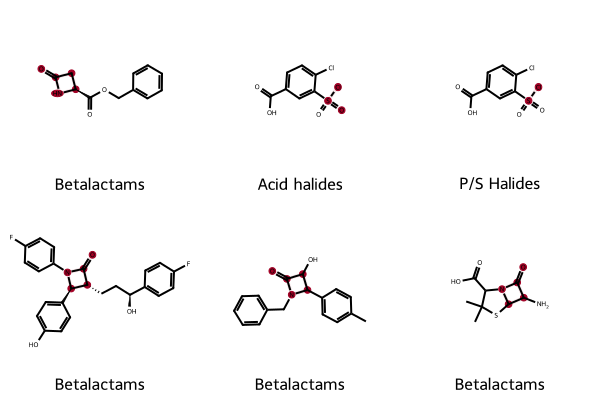

Match visualization saved to 'figures/ch02/glaxo_alerts_matches.svg'


In [67]:
def visualize_alert_matches(match_df, start_idx=2, n_matches=6):
    """
    Visualize molecules matching structural alerts, with the matching substructure highlighted.
    
    Parameters:
    -----------
    match_df : pandas.DataFrame
        DataFrame containing match information
    start_idx : int
        Index to start from
    n_matches : int
        Number of matches to visualize
        
    Returns:
    --------
    rdkit.Chem.Draw._MolsToGridImage
        Grid image of molecules with highlighted substructures
    """
    end_idx = start_idx + n_matches
    if end_idx > len(match_df):
        end_idx = len(match_df)
        print(f"Warning: Requested more matches than available. Showing {end_idx - start_idx} matches.")
    
    # Get molecules and matching substructures
    mols = match_df.mol.iloc[start_idx:end_idx].tolist()
    descriptions = match_df.description.iloc[start_idx:end_idx].tolist()
    
    # Find the atoms in each molecule that match the alert substructure
    highlights = [mol.GetSubstructMatch(alert) for mol, alert in 
                 zip(match_df.mol.iloc[start_idx:end_idx], match_df.alert.iloc[start_idx:end_idx])]
    
    # Calculate grid dimensions
    n_cols = min(3, n_matches)
    
    # Create the visualization
    drawing_options = setup_rdkit_drawing()
    drawing_options.setHighlightColour((.635, .0, .145, .1))  # Set highlight color to be more visible
    
    img = Draw.MolsToGridImage(
        mols,
        highlightAtomLists=highlights,
        molsPerRow=n_cols,
        legends=descriptions,
        useSVG=True,
        drawOptions=drawing_options
    )
    
    return img

# Visualize example matches if we have any
if 'glaxo_match_df' in locals() and not glaxo_match_df.empty:
    match_img = visualize_alert_matches(glaxo_match_df, start_idx=2, n_matches=6)
    display(match_img)
    
    # Save the visualization
    with open("figures/ch02/glaxo_alerts_matches.svg", "w") as f:
        f.write(match_img.data)
    print("Match visualization saved to 'figures/ch02/glaxo_alerts_matches.svg'")
else:
    print("No Glaxo alert matches to visualize.")

Let's summarize the results of our filtering process. This gives us an overview of how many compounds were removed at each step and what percentage of the original library remains after all filters have been applied:

In [68]:
def print_filtering_summary():
    """Print a summary of the filtering process"""
    original_count = len(specs)
    ro5_count = len(specs_ro5_compliant)
    pains_brenk_count = len(specs_ro5_pains_brenk_compliant)
    final_count = len(specs_filtered)
    
    print("Filtering Summary:")
    print(f"Original compound library size: {original_count}")
    print(f"After Lipinski's Rule of Five: {ro5_count} ({ro5_count/original_count*100:.1f}%)")
    print(f"After PAINS/BRENK filter: {pains_brenk_count} ({pains_brenk_count/original_count*100:.1f}%)")
    print(f"After Glaxo Wellcome filter: {final_count} ({final_count/original_count*100:.1f}%)")
    print(f"Total compounds removed: {original_count - final_count} ({(original_count - final_count)/original_count*100:.1f}%)")

# Print the filtering summary
print_filtering_summary()

Filtering Summary:
Original compound library size: 212670
After Lipinski's Rule of Five: 199481 (93.8%)
After PAINS/BRENK filter: 105566 (49.6%)
After Glaxo Wellcome filter: 105431 (49.6%)
Total compounds removed: 107239 (50.4%)


## <b> <font color='#A20025'> 4️⃣ Fingerprints: Representing Molecules as Numbers

To apply machine learning and similarity searching, we need to convert molecular structures into numerical representations called **fingerprints**. Molecular fingerprints encode the structural features of molecules as bit vectors, allowing us to:
 
1. Compute similarity between molecules
2. Apply machine learning algorithms
3. Perform fast substructure searching
 
Several types of fingerprints exist, but we'll focus on **Morgan fingerprints** (also known as ECFP - Extended Connectivity Fingerprints), which are among the most widely used in drug discovery.

### <b> <font color='#A20025'> Fingerprinting our Library

Morgan fingerprints (ECFPs) work by:
 
1. Assigning initial identifiers to each atom
2. Updating these identifiers based on neighboring atoms (within a specified radius)
3. Hashing these features to create a fixed-length bit vector
 
The radius parameter determines how many bonds away from each atom the algorithm considers, with larger radii capturing more extended features.

In [76]:
def generate_morgan_fingerprints(df, mol_col='mol', radius=2, n_bits=2048):
    """
    Generate Morgan fingerprints for a set of molecules.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame containing molecules
    mol_col : str
        Name of the column containing RDKit molecule objects
    radius : int
        Radius for the Morgan fingerprint algorithm
    n_bits : int
        Number of bits in the fingerprint
        
    Returns:
    --------
    pandas.DataFrame
        DataFrame with added fingerprint column
    """
    print(f"Generating Morgan fingerprints (radius={radius}, n_bits={n_bits})...")
    
    fp_col_name = f"morgan_fp_r{radius}_b{n_bits}"
    
    morgan_generator = GetMorganGenerator(radius=radius, fpSize=n_bits)
    
    def compute_fingerprint(mol):
        """Generate a Morgan fingerprint for a molecule"""
        if mol is None:
            return None
        return morgan_generator.GetFingerprint(mol)
    
    df.loc[:,fp_col_name] = df[mol_col].apply(compute_fingerprint)
    
    print(f"Fingerprints generated and stored in column '{fp_col_name}'")
    return df, fp_col_name

# Generate fingerprints for our filtered compounds
specs_filtered, fp_col_name = generate_morgan_fingerprints(specs_filtered)


Generating Morgan fingerprints (radius=2, n_bits=2048)...
Fingerprints generated and stored in column 'morgan_fp_r2_b2048'


To better understand how Morgan fingerprints work, let's visualize how a molecule is decomposed into the structural features that are encoded in the fingerprint:

Original Molecule:


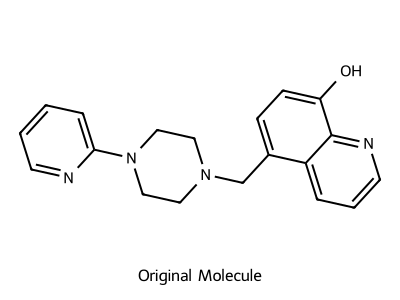


Showing 5 of 40 total fingerprint features:
Feature 1 (Bit 74):


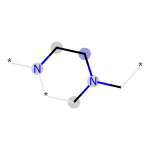

Feature 2 (Bit 80):


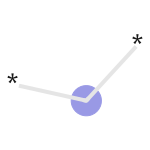

Feature 3 (Bit 278):


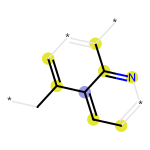

Feature 4 (Bit 378):


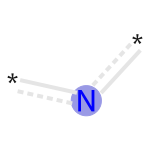

Feature 5 (Bit 407):


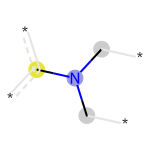

In [82]:
def visualize_fingerprint_decomposition(mol, n_features=5, radius=2):
    """
    Visualize the structural features that contribute to a molecule's fingerprint.
    
    Parameters:
    -----------
    mol : rdkit.Chem.rdchem.Mol
        RDKit molecule object
    n_features : int
        Number of fingerprint features to visualize
    radius : int
        Radius for the Morgan fingerprint
        
    Returns:
    --------
    list
        List of SVG images of the structural features
    """
    # Function to draw a fragment from a specific bit
    def draw_fragment_from_bit(mol, bit_number, bit_info):
        """Draw the fragment corresponding to a specific bit in the fingerprint"""
        try:
            svg = Draw.DrawMorganBit(mol, bit_number, bit_info, useSVG=True)
            return svg
        except Exception as e:
            print(f"Error drawing bit {bit_number}: {str(e)}")
            return None
    
    # First, draw the entire molecule
    mol_img = Draw.MolsToGridImage(
        mols=[mol], 
        molsPerRow=1, 
        subImgSize=(400, 300),
        useSVG=True, 
        drawOptions=rdkit_drawing_options,
        legends=["Original Molecule"]
    )
    
    print("Original Molecule:")
    display(mol_img)
    
    # Save the original molecule image
    with open(f"figures/ch02/fp_decomposition_example_mol.svg", "w") as f:
        f.write(mol_img.data)
    
    # Generate the fingerprint and get bit info
    ao = AdditionalOutput()
    ao.AllocateBitInfoMap()
    morgan_generator = GetMorganGenerator(radius=radius, fpSize=2048)
    fp = morgan_generator.GetFingerprint(mol, additionalOutput=ao)
    
    # Get the indices of set bits
    set_bits = [idx for idx, bit in enumerate(fp) if bit]
    if not set_bits:
        print("No bits set in the fingerprint")
        return []
    
    # Limit to the requested number of features
    feature_bits = set_bits[:n_features]
    print(f"\nShowing {len(feature_bits)} of {len(set_bits)} total fingerprint features:")
    
    # Generate and display images for each feature
    bit_images = []
    for i, bit_idx in enumerate(feature_bits):
        bit_img = draw_fragment_from_bit(mol, bit_idx, ao.GetBitInfoMap())
        if bit_img:
            print(f"Feature {i+1} (Bit {bit_idx}):")
            display(bit_img)
            bit_images.append(bit_img)
            
            # Save the feature image
            with open(f"figures/ch02/fp_decomposition_bit{i}.svg", "w") as f:
                f.write(bit_img.data)
    
    return bit_images

# Visualize fingerprint decomposition for a sample molecule
example_mol = specs_filtered.mol.iloc[0]
feature_images = visualize_fingerprint_decomposition(example_mol, n_features=5)

## <b> <font color='#A20025'> 5️⃣ Similarity Searching

Now that we have a filtered compound library and molecular fingerprints, we can perform similarity searching to identify compounds that are structurally similar to known active molecules.
 
For this example, we'll use the Malaria Box, a set of compounds with known antimalarial activity, as our query molecules. The Malaria Box is a collection of 400 compounds with confirmed activity against malaria parasites. These compounds were selected from screening campaigns of millions of compounds and made freely available to researchers to catalyze drug development for malaria and other neglected diseases. We'll search our filtered library for compounds that are similar to these known actives, which might have similar biological activity.

In [83]:
def load_malaria_box():
    """
    Load the Malaria Box dataset.
    
    Returns:
    --------
    pandas.DataFrame
        DataFrame containing Malaria Box compounds
    """
    try:
        # Load the Excel file
        malaria_df = pd.read_excel(
            "data/ch02/MalariaBox400compoundsDec2014.xls", 
            usecols=["HEOS_COMPOUND_ID", "Smiles"]
        )
        
        # Add RDKit molecules
        PandasTools.AddMoleculeColumnToFrame(malaria_df, 'Smiles', 'mol')
        
        # Remove invalid molecules
        valid_mol_count = malaria_df['mol'].notnull().sum()
        invalid_mol_count = malaria_df['mol'].isnull().sum()
        
        if invalid_mol_count > 0:
            print(f"Removed {invalid_mol_count} invalid molecules from Malaria Box")
            malaria_df = malaria_df[malaria_df['mol'].notnull()]
        
        print(f"Loaded {len(malaria_df)} valid compounds from Malaria Box")
        return malaria_df
    
    except Exception as e:
        print(f"Error loading Malaria Box: {str(e)}")
        return None

# Load the Malaria Box
malaria_box = load_malaria_box()

if malaria_box is not None:
    # Display a few example compounds
    print("\nExample Malaria Box compounds:")
    display(malaria_box.head(3))
    
    # Generate fingerprints for Malaria Box compounds
    malaria_box, malaria_fp_col = generate_morgan_fingerprints(malaria_box)
else:
    print("Could not load Malaria Box. Similarity searching cannot proceed.")

Error loading Malaria Box: Missing optional dependency 'xlrd'. Install xlrd >= 2.0.1 for xls Excel support Use pip or conda to install xlrd.
Could not load Malaria Box. Similarity searching cannot proceed.


### <b> <font color='#A20025'> Searching against a Query

There are several methods to quantify the similarity between molecular fingerprints. The two most common are:
 
1. **Tanimoto similarity** (also called Jaccard similarity): The ratio of the number of common bits to the total number of bits set in either fingerprint.
2. **Dice similarity**: Similar to Tanimoto but gives more weight to common features.
 
Let's compute both similarity metrics between a query molecule from the Malaria Box and our filtered compound library:


In [ ]:
def compute_similarity_to_query(query_fp, fp_list):
    """
    Compute similarity between a query fingerprint and a list of fingerprints.
    
    Parameters:
    -----------
    query_fp : rdkit.DataStructs._VectInt
        Query fingerprint
    fp_list : list
        List of fingerprints to compare against
        
    Returns:
    --------
    tuple
        Tanimoto and Dice similarity scores
    """
    tanimoto_sim = DataStructs.BulkTanimotoSimilarity(query_fp, fp_list)
    dice_sim = DataStructs.BulkDiceSimilarity(query_fp, fp_list)
    return tanimoto_sim, dice_sim

def analyze_similarity_scores(df, tanimoto_scores, dice_scores):
    """
    Analyze similarity scores distribution.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame to add scores to
    tanimoto_scores : list
        Tanimoto similarity scores
    dice_scores : list
        Dice similarity scores
        
    Returns:
    --------
    pandas.DataFrame
        DataFrame with added similarity scores
    """
    # Add scores to the dataframe
    df['tanimoto_sim'] = tanimoto_scores
    df['dice_sim'] = dice_scores
    
    # Basic statistics
    print("Similarity Score Statistics:")
    print("\nTanimoto Similarity:")
    print(f"Min: {min(tanimoto_scores):.4f}")
    print(f"Max: {max(tanimoto_scores):.4f}")
    print(f"Mean: {np.mean(tanimoto_scores):.4f}")
    print(f"Median: {np.median(tanimoto_scores):.4f}")
    
    print("\nDice Similarity:")
    print(f"Min: {min(dice_scores):.4f}")
    print(f"Max: {max(dice_scores):.4f}")
    print(f"Mean: {np.mean(dice_scores):.4f}")
    print(f"Median: {np.median(dice_scores):.4f}")
    
    return df

# Check if we have both datasets before proceeding
if 'malaria_box' in locals() and 'specs_filtered' in locals() and len(malaria_box) > 0:
    # Select a query molecule from the Malaria Box (index 236 as in the original script)
    query_idx = 236
    if query_idx < len(malaria_box):
        query_fp = malaria_box[malaria_fp_col].iloc[query_idx]
        query_mol = malaria_box.mol.iloc[query_idx]
        
        print(f"Selected Malaria Box compound #{query_idx} as query:")
        query_img = Draw.MolsToGridImage(
            mols=[query_mol], 
            molsPerRow=1, 
            subImgSize=(400, 300),
            useSVG=True, 
            drawOptions=rdkit_drawing_options
        )
        display(query_img)
        
        # Save the query molecule image
        with open("figures/ch02/example_malaria_box_mol.svg", "w") as f:
            f.write(query_img.data)
        
        # Get fingerprints from the filtered library
        library_fps = specs_filtered[fp_col_name].tolist()
        
        # Compute similarity scores
        print("\nComputing similarity scores...")
        tanimoto_scores, dice_scores = compute_similarity_to_query(query_fp, library_fps)
        
        # Analyze scores
        specs_filtered = analyze_similarity_scores(specs_filtered, tanimoto_scores, dice_scores)
    else:
        print(f"Query index {query_idx} is out of range for Malaria Box with {len(malaria_box)} compounds")
else:
    print("Similarity searching cannot proceed without both datasets")

Let's visualize molecules with high and low similarity to our query molecule to understand what structural features contribute to similarity:

In [ ]:
def visualize_similarity_extremes(df, sim_col, sim_col_2=None, n=3):
    """
    Visualize molecules with highest and lowest similarity scores.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame containing molecules and similarity scores
    sim_col : str
        Name of the similarity score column
    sim_col_2 : str
        Name of a second similarity score column (optional)
    n : int
        Number of molecules to show from each extreme
        
    Returns:
    --------
    rdkit.Chem.Draw._MolsToGridImage
        Grid image of molecules
    """
    # Order by similarity
    df_ordered = df.sort_values([sim_col], ascending=False).reset_index(drop=True)
    
    # Get highest and lowest similarity molecules
    extremes = pd.concat([df_ordered[:n], df_ordered.dropna()[-n:]])
    
    # Create legends
    if sim_col_2:
        legend_text = [f"Tani: {x:.2f}\nDice: {y:.2f}" for x, y in 
                      zip(extremes[sim_col], extremes[sim_col_2])]
    else:
        legend_text = [f"{x:.2f}" for x in extremes[sim_col]]
    
    # Create the visualization
    img = Draw.MolsToGridImage(
        extremes.mol, 
        molsPerRow=n, 
        subImgSize=(300, 250),
        legends=legend_text, 
        useSVG=True, 
        drawOptions=rdkit_drawing_options
    )
    
    return img

# Visualize similarity extremes if we have similarity scores
if 'specs_filtered' in locals() and 'tanimoto_sim' in specs_filtered.columns:
    sim_img = visualize_similarity_extremes(
        specs_filtered, 
        sim_col="tanimoto_sim", 
        sim_col_2="dice_sim", 
        n=3
    )
    display(sim_img)
    
    # Save the visualization
    with open("figures/ch02/example_tani_dice_sim.svg", "w") as f:
        f.write(sim_img.data)
    print("Similarity visualization saved to 'figures/ch02/example_tani_dice_sim.svg'")
    
    # Visualize the relationship between Tanimoto and Dice similarity
    plt.figure(figsize=(10, 8))
    
    # Create a joint plot
    joint_plot = sns.jointplot(
        data=specs_filtered,
        x="tanimoto_sim",
        y="dice_sim",
        kind="hex",
        cmap="viridis",
        height=8
    )
    
    joint_plot.set_axis_labels("Tanimoto Similarity", "Dice Similarity", fontsize=12)
    
    # Add a title
    plt.suptitle("Relationship Between Tanimoto and Dice Similarity", 
                y=1.02, fontsize=16)
    
    plt.tight_layout()
    
    # Save the figure
    plt.savefig('figures/ch02/sim_pairplot.png', bbox_inches='tight', dpi=600)
    plt.savefig('figures/ch02/sim_pairplot.pdf', bbox_inches='tight', dpi=600)
    

Instead of just searching against a single Malaria Box compound, let's identify all compounds in our library that are similar to any of the Malaria Box compounds. This is a more realistic virtual screening scenario, where we're looking for any compound that might have similar activity to our reference set.

In [ ]:
def search_similar_compounds(query_fps, library_fps, similarity_threshold=0.65):
    """
    Find compounds in a library that are similar to any query compound.
    
    Parameters:
    -----------
    query_fps : list
        List of query fingerprints
    library_fps : list
        List of library fingerprints
    similarity_threshold : float
        Minimum similarity score to consider
        
    Returns:
    --------
    dict
        Dictionary mapping library compound indices to their maximum similarity score
    """
    from collections import defaultdict
    
    # Initialize matches dictionary with default value 0
    matches = defaultdict(int)
    
    print(f"Searching for compounds with dice similarity ≥ {similarity_threshold}...")
    print(f"Comparing {len(query_fps)} query compounds against {len(library_fps)} library compounds")
    
    # Progress counter
    counter = 0
    update_frequency = max(1, len(query_fps) // 10)  # Update progress 10 times
    
    # Compare each query against the library
    for query_fp in query_fps:
        # Compute Dice similarity
        dice_sim = DataStructs.BulkDiceSimilarity(query_fp, library_fps)
        
        # Update matches with maximum similarity for each library compound
        for idx, sim in enumerate(dice_sim):
            if sim >= similarity_threshold:
                matches[idx] = max(sim, matches[idx])
        
        # Update progress
        counter += 1
        if counter % update_frequency == 0 or counter == len(query_fps):
            print(f"Progress: {counter}/{len(query_fps)} queries processed "
                  f"({counter/len(query_fps)*100:.1f}%)")
    
    print(f"Found {len(matches)} compounds with similarity ≥ {similarity_threshold}")
    return matches

def select_top_matches(matches, budget=1000):
    """
    Select the top matches up to a budget constraint.
    
    Parameters:
    -----------
    matches : dict
        Dictionary mapping compound indices to similarity scores
    budget : int
        Maximum number of compounds to select
        
    Returns:
    --------
    list
        Indices of the top compounds
    """
    import heapq
    
    # Convert to a list of (similarity, index) tuples
    heap = []
    for idx, sim in matches.items():
        # Use negative similarity for max-heap (Python has min-heap by default)
        heapq.heappush(heap, (-1 * sim, idx))
    
    # Pop top matches up to budget
    top_matches = []
    for i in range(min(budget, len(heap))):
        neg_sim, idx = heapq.heappop(heap)
        sim = -1 * neg_sim  # Convert back to positive similarity
        top_matches.append((idx, sim))
    
    print(f"Selected top {len(top_matches)} compounds (budget: {budget})")
    return top_matches

# Check if we have both datasets before proceeding
if 'malaria_box' in locals() and 'specs_filtered' in locals() and len(malaria_box) > 0:
    # Get fingerprints
    query_fps = malaria_box[malaria_fp_col].tolist()
    library_fps = specs_filtered[fp_col_name].tolist()
    
    # Search for similar compounds
    matches = search_similar_compounds(query_fps, library_fps, similarity_threshold=0.65)
    
    # Select top matches
    top_matches = select_top_matches(matches, budget=1000)
    
    if top_matches:
        # Extract hits
        hit_indices = [idx for idx, sim in top_matches]
        hit_similarities = [sim for idx, sim in top_matches]
        
        specs_hits = specs_filtered.iloc[hit_indices].copy()
        specs_hits['max_dice_sim'] = hit_similarities
        
        # Display statistics about the hits
        print("\nHit Statistics:")
        print(f"Mean similarity: {np.mean(hit_similarities):.4f}")
        print(f"Median similarity: {np.median(hit_similarities):.4f}")
        print(f"Min similarity: {min(hit_similarities):.4f}")
        print(f"Max similarity: {max(hit_similarities):.4f}")
        
        # Save the hits
        output_file = "artifacts/ch02/specs_hits_to_malaria_box.csv"
        specs_hits.to_csv(
            output_file, 
            columns=["PUBCHEM_SUBSTANCE_ID", "smiles", "max_dice_sim"], 
            index=False
        )
        print(f"\nSaved {len(specs_hits)} hits to {output_file}")
        
        # Visualize a few top hits
        top_n = 6
        if len(specs_hits) >= top_n:
            print(f"\nVisualizing top {top_n} hits:")
            top_hits = specs_hits.sort_values('max_dice_sim', ascending=False).head(top_n)
            
            hits_img = Draw.MolsToGridImage(
                top_hits.mol, 
                molsPerRow=3, 
                subImgSize=(300, 250),
                legends=[f"Dice: {sim:.2f}" for sim in top_hits.max_dice_sim], 
                useSVG=True, 
                drawOptions=rdkit_drawing_options
            )
            display(hits_img)
    else:
        print("No hits found meeting the similarity threshold")
else:
    print("Similarity searching cannot proceed without both datasets")

## <b> <font color='#A20025'> Summary

In this notebook, we've covered:
 
1. **Compound Library Preparation**:
    - Loading a compound library from an SDF file
    - Calculating molecular descriptors
 
2. **Compound Filtering**:
    - Property-based filtering using Lipinski's Rule of Five
    - Structure-based filtering to remove problematic compounds (PAINS, BRENK, Glaxo Wellcome alerts)
 
3. **Fingerprint Generation**:
    - Creating Morgan fingerprints to represent molecules numerically
    - Visualizing the structural features encoded in fingerprints
 
4. **Similarity Searching**:
    - Computing Tanimoto and Dice similarity between molecules
    - Finding compounds in our library that are similar to known antimalarial compounds
 
These techniques form the foundation of ligand-based virtual screening, which is a powerful approach for drug discovery, especially when the 3D structure of the target is unknown.

## <b> <font color='#A20025'> Interactive Exploration

Here are some ideas for further exploration:
 
1. Try different fingerprint types (MACCS keys, topological fingerprints) and compare their performance
2. Experiment with different similarity thresholds and see how they affect the number and diversity of hits
3. Apply different property filters to see their impact on the library composition
4. Search for compounds similar to other bioactive molecules (e.g., from ChEMBL or PubChem)

*See the book for more exercises.*

## <b> <font color='#A20025'> References

[1] Zhang, M.Q., Wilkinson, B. (2007), Drug discovery beyond the ‘rule-of-five’. Curr. Opin. Biotechnol., 16 (6): 478-488. https://doi.org/10.1016/j.copbio.2007.10.005

[2] Benet, L.Z., Hosey, C.M., Ursu, O., Oprea, T.I. (2016), BDDCS, the Rule of 5 and drugability. Adv. Drug. Deliv. Rev., 101: 89-98. https://doi.org/10.1016/j.addr.2016.05.007

[3] Roy, K.K. (2017). Targeting the active sites of malarial proteases for antimalarial drug discovery: approaches, progress and challenges. International Journal of Antimicrobial Agents, 50 (3): 287-302

[4] Shibeshi, M.A., Kifle, Z.D., & Atnafie, S.A. (2020). Antimalarial Drug Resistance and Novel Targets for Antimalarial Drug Discovery. Infection and drug resistance, 13, 4047–4060. https://doi.org/10.2147/IDR.S279433

[5] Mesén-Ramírez, P., Bergmann, B., Tran, T.T., Garten, M., Stäcker, J., et al. (2019). EXP1 is critical for nutrient uptake across the parasitophorous vacuole membrane of malaria parasites. PLOS Biology, 17 (9). https://doi.org/10.1371/journal.pbio.3000473 

[6] Neves, B.J., Braga, R.C., Alves, V. M., Lima, M. N. N., Cassiano, G. C., et al. (2020). Deep Learning-driven research for drug discovery: Tackling Malaria. PLOS Comput. Biol., 16 (2). https://doi.org/10.1371/journal.pcbi.1007025 

[7] Zhang, L., Fourches, D., Sedykh, A., et al. (2013). Discovery of Novel Antimalarial Compounds Enabled by QSAR-Based Virtual Screening. J. Chem. Inf. Model., 53 (2): 475-492. https://doi.org/10.1021/ci300421n 

[8] Malaria Box supporting information. Medicines for Malaria Venture. https://www.mmv.org/mmv-open/malaria-box/malaria-box-supporting-information

[9] Getting Started with the RDKit in Python. RDKit. https://www.rdkit.org/docs/GettingStartedInPython.html

[10] RDKit Cookbook. RDKit. https://www.rdkit.org/docs/Cookbook.html

[11] Handbook of Molecular Descriptors. https://onlinelibrary.wiley.com/doi/book/10.1002/9783527613106

[12] Lipinski, C.A., Lombardo, F., Dominy, B.W., Feeney, P.J. (2001). Experimental and computational approaches to estimate solubility and permeability in drug discovery and development settings. Advanced Drug Delivery Reviews. 46 (1–3): 3–26. doi:10.1016/S0169-409X(00)00129-0. PMID 11259830

[13] Brenk, R., Schipani, A., James, D., Krasowski, A., Gilbert, I.H., Frearson, J., & Wyatt, P.G. (2008). Lessons learnt from assembling screening libraries for drug discovery for neglected diseases. Chem. Med. Chem., 3 (3): 435–444. https://doi.org/10.1002/cmdc.200700139

[14] Walters, W.P., Stahl, M.T., Murcko, M.A. (1998). Virtual Screening -- An Overview. Drug Discov. Today. 3: 160–178

[15] SMARTS – A Language for Describing Molecular Patterns. Daylight Manual. https://www.daylight.com/dayhtml/doc/theory/theory.smarts.html

[16] https://github.com/rdkit/rdkit/blob/master/rdkit/Chem/MACCSkeys.py

[17] Fingerprints – Screening and Similarity. Daylight Manual. https://www.daylight.com/dayhtml/doc/theory/theory.finger.html#RTFToC83